In [1]:
from PIL import Image

from transformers import SamModel, SamProcessor

from diffusers import DiffusionPipeline, AutoPipelineForInpainting

from diffusers.utils import make_image_grid

import torch

import numpy as np

## 1) Load the Segment Anything Model (SAM)
#### The model we will load is "facebook/sam-vit-base". Image-based models are computationally intense, so it becomes crucial to run them on GPUs.
#### Here we are letting the model to use the GPU ( "cuda" )
#### We will also load the SAM processor, which is needed to preprocess the image to create inputs to the SAM model and to post-process to outputs from the model.

In [2]:
# Load the SAM model on the GPU by adding .to("cuda")
sam_model = SamModel.from_pretrained( "facebook/sam-vit-base" ).to( "cuda" )

# Load the SamProcessor using the facebook/sam-vit-base
sam_processor = SamProcessor.from_pretrained( "facebook/sam-vit-base" )

## 2) Load the Input Image and Create Image Mask
#### Here, I am using my own headshot photo. 
#### The following are the steps to create an image mask:

* Load the image and convert it into RGB format
* Ensure the image size is 512 x 512
* Create a couple of points on the image to select the 'subject' of interest. (In this case, there are two points to select the face in the picture)
* Using the SAM processor, preprocess the RGB-formatted image to create the inputs for the SAM model
* Run the SAM model using the inputs
* Using the SAM processor again, post-process the SAM model outputs to extract the masks. (Note that in this case, the extracted mask is for the subject)
* Select the mask with the maximum IOU score as the best mask for the subject
* Note that inverting the selected best mask will result in a mask for the rest of the image (background). 

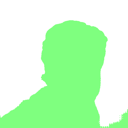

In [3]:
raw_image = Image.open( "Murali_Kashaboina.png" ).convert( "RGB" ).resize((512, 512))

# These are the coordinates of two points on the image to capture the head
input_points = [[[50, 20], [95, 140]]]

# Use the processor to generate the right inputs. Note that the generated inputs are in PyTorch tensors format.
inputs = sam_processor( raw_image, input_points=input_points, return_tensors="pt" ).to( "cuda" )
    
# Run the SAM model
outputs = sam_model( **inputs )
    
# Post-process SAM outputs to obtain the masks
masks = sam_processor.image_processor.post_process_masks(
   outputs.pred_masks.cpu(), 
   inputs["original_sizes"].cpu(), 
   inputs["reshaped_input_sizes"].cpu()
)

# Select the mask with the highest IOU score implying a confident mask. 
subject_mask = masks[0][0][outputs.iou_scores.argmax()] 

# Inverting the subject mask using the ~ operator will assign a value of 1 to the subject pixels and a value of 0 to the rest of the pixels.
# Inverting the subject mask essentially results in the background mask, where background pixels have a value of 0
bg_mask = ~subject_mask

subject_mask = subject_mask.cpu().numpy()

bg_mask = bg_mask.cpu().numpy()

# Display the subject mask in green while making the background transparent. Only for display purposes
# Assign Green pixel values using the color vector [Red, Green, Blue, Alpha] to only subject pixels using pixel filtration by value (a value of 1)
bg_transparent_mask = np.zeros( bg_mask.shape + (4, ), dtype=np.uint8 )

bg_transparent_mask[ bg_mask == 1 ] = [0, 255, 0, 127]

Image.fromarray( bg_transparent_mask ).resize((128, 128))

## 3) Load the Diffusion Model for Inpainting
#### The diffusion model used is "diffusers/stable-diffusion-xl-1.0-inpainting-0.1"
#### Note that the diffusion model has millions of parameters. To optimize the memory, floating point type 'float16' is used to load the model parameters
#### To make the large image model more efficient on the local hardware, CPU offloading is enabled on the model to offload non-tensor-like computations

In [4]:
diffuser_pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16
)

diffuser_pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


## 4) Create the Prompt and Negative Prompt
#### Prompt and negative prompt are fed into the diffusion model as textual inputs. While prompt is used to instruct the diffusion model to inpaint,
#### the negative prompt will dictate the model to not-to-do or prevent what is instructed in the negative prompt

In [5]:
prompt = "a man on the moon with the blue earth in the sky background"
negative_prompt = "artifacts, low quality, distortion"

## 5) Invoke Diffusion Model to Inpaint Using Prompts and Input Image as Modalities

In [6]:
subject_mask_image = Image.fromarray( subject_mask )

seed = 2442

random_generator = torch.manual_seed( seed )

image = diffuser_pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=raw_image,
    mask_image=subject_mask_image,
    generator=random_generator,
    guidance_scale=7
).images[0]

  0%|          | 0/49 [00:00<?, ?it/s]

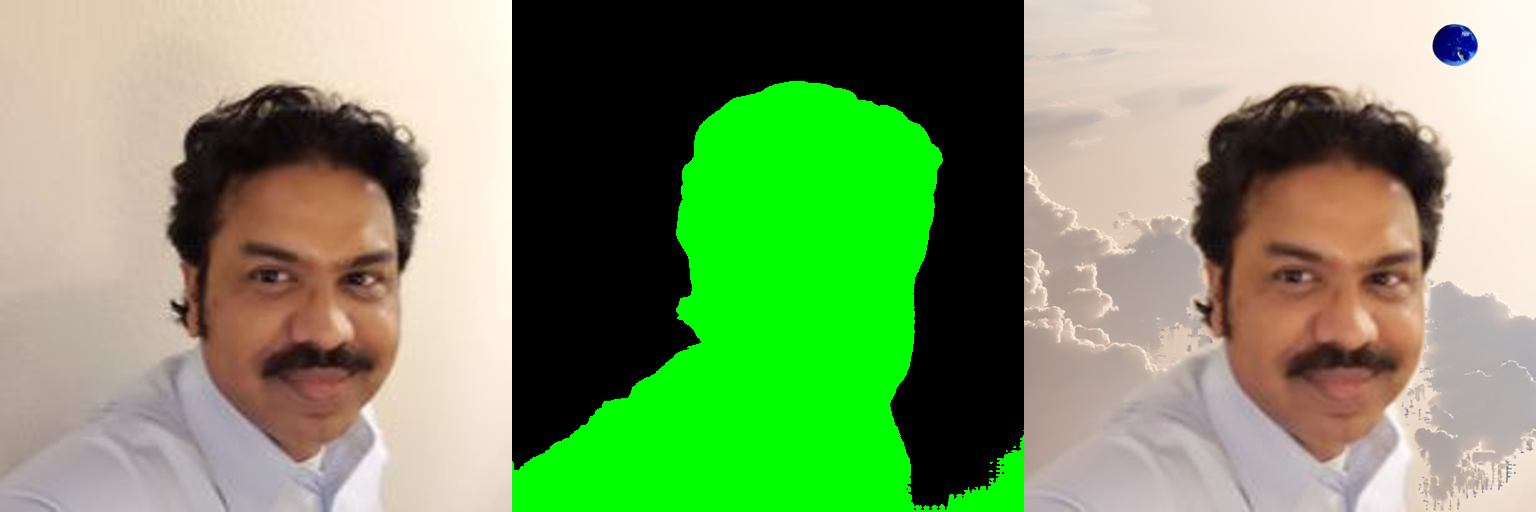

In [7]:
fig = make_image_grid( [raw_image, Image.fromarray( bg_transparent_mask ), image.resize((512, 512))], rows=1, cols=3 )
fig

In [9]:
fig.save( "Diffusion_GenAI_Output.png" )